In [1]:
import pandas as pd
import numpy as np
import pymc as pm
from src.data_utils import load_and_process_data
from src.model import run_full_analysis
from src.trace_save_load import load_previous_season_trace, extract_previous_season_priors
import matplotlib.pyplot as plt

league = ['Premier_League', 'Championship']
match_date = '2025-01-01'


# Simple one-liner to get everything ready
df, team_mapping, n_teams = load_and_process_data(
    db_path=r'C:\Users\Owner\dev\algobetting\infra\data\db\fotmob.db',
    league=league, 
    #season=season,
    match_date=match_date,
    max_goals=9,
    decay_rate=0.002,
    goals_weight=0.5,
    xg_weight=0.5,
    psxg_weight=0.3

)

df

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,match_id,league_id,match_date,home_team,away_team,home_goals,away_goals,weight,days_ago,is_actual,poisson_binomial_xg_prob,poisson_binomial_psxg_prob,poisson_xg_total_prob,home_idx,away_idx
0,4506333,Premier_League,2025-02-26,Brentford,Everton,0,0,0.007607,199,False,0.009818,0.003770,0.038510,4,13
1,4506333,Premier_League,2025-02-26,Brentford,Everton,0,1,0.015016,199,False,0.020118,0.034389,0.059852,4,13
2,4506333,Premier_League,2025-02-26,Brentford,Everton,0,2,0.020551,199,False,0.017061,0.106069,0.046511,4,13
3,4506333,Premier_League,2025-02-26,Brentford,Everton,0,3,0.017628,199,False,0.007937,0.117316,0.024096,4,13
4,4506333,Premier_League,2025-02-26,Brentford,Everton,0,4,0.004053,199,False,0.002277,0.020599,0.009362,4,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13675,4813414,Premier_League,2025-09-13,West Ham,Tottenham,3,1,0.000963,0,False,0.004998,0.000144,0.008579,42,39
13676,4813414,Premier_League,2025-09-13,West Ham,Tottenham,3,2,0.000634,0,False,0.003315,0.000297,0.005527,42,39
13677,4813414,Premier_League,2025-09-13,West Ham,Tottenham,3,3,0.000278,0,False,0.001285,0.000220,0.002374,42,39
13678,4813414,Premier_League,2025-09-13,West Ham,Tottenham,4,0,0.000120,0,False,0.000176,0.000000,0.001084,42,39


Season: 2025
Teams: 44
Model version: v1
Samples: 1000 (tune: 500)

Building and sampling model...


The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Analyzing results...
MODEL ANALYSIS RESULTS

1. PARAMETER SUMMARY STATISTICS
----------------------------------------
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
att_str_raw[0]   0.230  0.155  -0.048    0.524      0.021    0.015      49.0   
att_str_raw[1]   0.111  0.155  -0.190    0.383      0.021    0.015      49.0   
att_str_raw[2]  -0.157  0.152  -0.433    0.127      0.021    0.015      48.0   
att_str_raw[3]   0.195  0.154  -0.091    0.482      0.021    0.015      51.0   
att_str_raw[4]   0.219  0.154  -0.058    0.515      0.021    0.015      50.0   
att_str_raw[5]   0.307  0.155   0.019    0.597      0.021    0.016      50.0   
att_str_raw[6]  -0.110  0.153  -0.372    0.187      0.022    0.015      48.0   
att_str_raw[7]  -0.040  0.153  -0.299    0.266      0.022    0.015      48.0   
att_str_raw[8]  -0.151  0.153  -0.420    0.144      0.021    0.015      49.0   
att_str_raw[9]   0.258  0.154  -0.026    0.548      0.021    0.015      52.0   
a

c:\Users\Owner\dev\algobetting\algo\models\team_strength\bayesian-multilevel\src\model.py:150: RuntimeWarning: invalid value encountered in scalar divide
  observed_goals_per_match = observed_total_goals / observed_matches


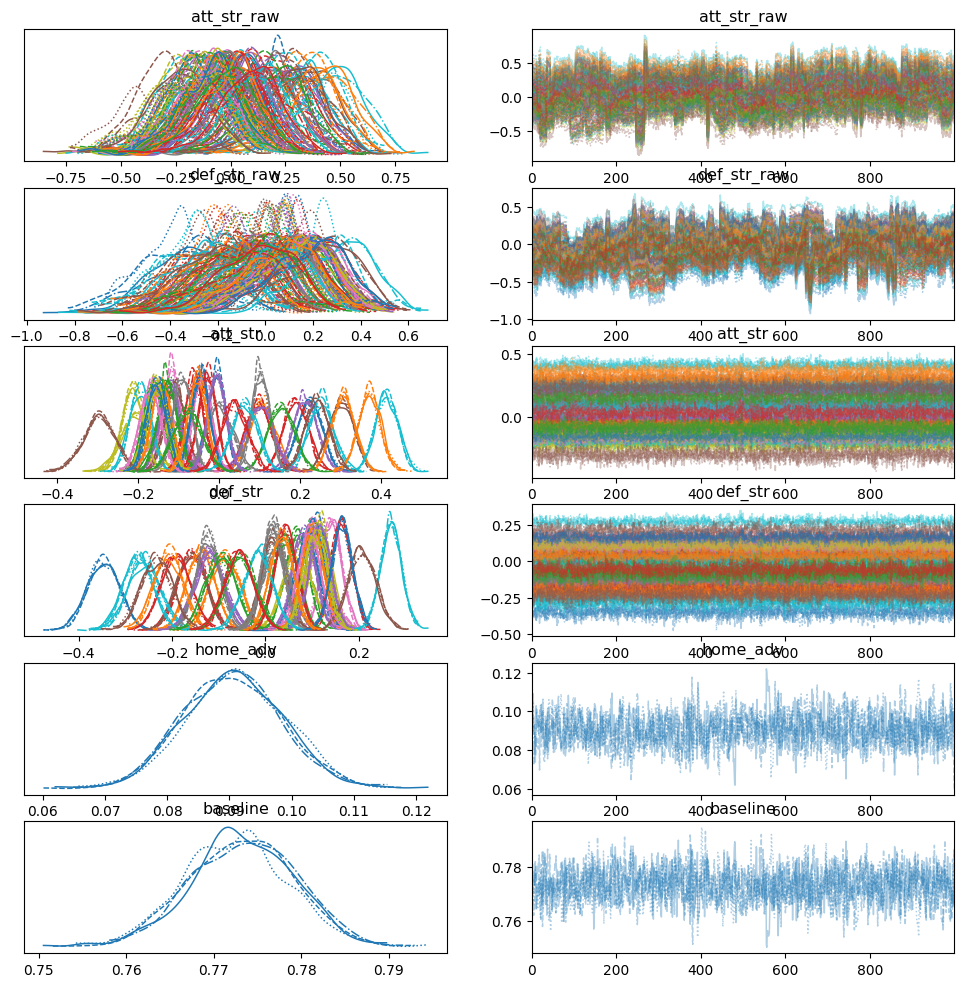

In [2]:
model, trace, results = run_full_analysis(
    train_df=df,
    teams=list(team_mapping.keys()),  
    season=2025,
    n_teams=n_teams,
    trace_samples=1000,
    tune_samples=500
)